In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saikrishnagummalla","key":"e3f053141e25f48b369759649dc594c5"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

100% 810M/812M [00:21<00:00, 43.1MB/s]
100% 812M/812M [00:21<00:00, 40.1MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

Question-1

Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?

A convolutional neural network needs to be created from scratch. As we have uploaded the dataset from kaggle already, lets create our subsets from the dataset which are training, validation and testing. We will be taking 1000 images for training, 500 images for validation and 500 images for testing.

In [6]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=500)
make_subset("validation", start_index=500, end_index=1000)
make_subset("test", start_index=1000, end_index=2000)


Constructing the model

Images which is 3D tensor in this case, are our input for this network, but they must first be transformed.Next, we use maxpooling with a 2x2 window (pool_size) and convolution with a 3x3 window (kernel_size).

This assignment has the main goal of classifying images if that's a cat or a dog. To build in the dense layer, we need a layer that changes the 3D shape into 1D.

Launching a small convolution for classifying cats and dogs

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

We can see that there are 991,041 parameters to optimize.

**Building the model for training**

In [9]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Data preprocessing**

We will be using image_dataset_from_directory to read the images

This code modifies the images to tensors as stated above in their respective folders of training,validation and test.

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

dataset_Training = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
dataset_Validation = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
dataset_Testing = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [11]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
data = tf.data.Dataset.from_tensor_slices(random_numbers)

In [12]:
for i, element in enumerate(data):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [13]:
data_batch = data.batch(32)
for i, element in enumerate(data_batch):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [14]:
data_reshaped = data.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(data_reshaped):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [15]:
for data_batch, labels_batch in dataset_Training:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Applying the model**

Callbacks is used for this since there is no need of remodeling as callbacks will automatically store files containing the weights generated from the best epoch.

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    dataset_Training,
    epochs=30,
    validation_data=dataset_Validation,
    callbacks=callbacks)

Epoch 1/30
32/32 [==============================] - 6s 46ms/step - loss: 0.7050 - accuracy: 0.5250 - val_loss: 0.7207 - val_accuracy: 0.5000
Epoch 2/30
32/32 [==============================] - 1s 29ms/step - loss: 0.6963 - accuracy: 0.5160 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 3/30
32/32 [==============================] - 1s 27ms/step - loss: 0.7187 - accuracy: 0.5340 - val_loss: 0.7044 - val_accuracy: 0.5000
Epoch 4/30
32/32 [==============================] - 1s 27ms/step - loss: 0.6923 - accuracy: 0.5490 - val_loss: 0.7099 - val_accuracy: 0.5050
Epoch 5/30
32/32 [==============================] - 1s 30ms/step - loss: 0.6787 - accuracy: 0.5620 - val_loss: 0.6697 - val_accuracy: 0.6130
Epoch 6/30
32/32 [==============================] - 1s 27ms/step - loss: 0.6875 - accuracy: 0.6170 - val_loss: 0.7838 - val_accuracy: 0.5030
Epoch 7/30
32/32 [==============================] - 1s 26ms/step - loss: 0.6514 - accuracy: 0.6290 - val_loss: 0.7056 - val_accuracy: 0.5190
Epoch 8/30
32

**Here are the loss and accuracy curves for the training model**

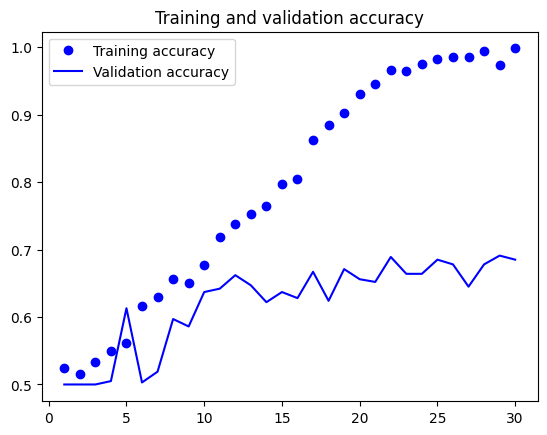

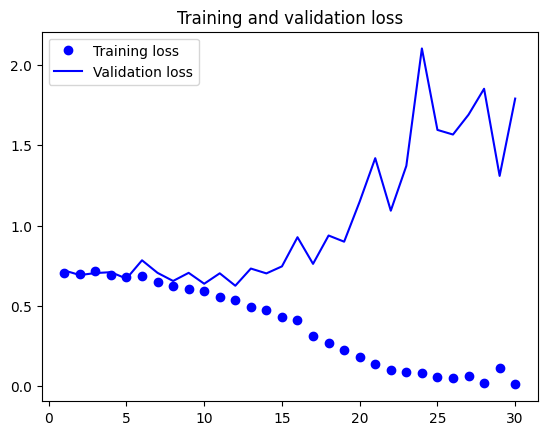

In [17]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Checking this model on the test set**

In [18]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(dataset_Testing)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 11ms/step - loss: 0.6322 - accuracy: 0.6415
Test accuracy: 0.641


From the above output, we can see that the test accuracy is too low of 65%, therefore, to improve this model, we will be training our model with the below techniques:

a) Data Augmentation

b) Drop out Method

c) Data Augmentation and drop out method

**a) Data Augmentation:**

Applying data augmentation to image model:

In [19]:
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Building a new convnet

In [20]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the convnet

In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    dataset_Training,
    epochs=100,
    validation_data=dataset_Validation,
     callbacks=callbacks)

Epoch 1/100
32/32 [==============================] - 3s 35ms/step - loss: 0.7005 - accuracy: 0.5070 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 1s 31ms/step - loss: 0.6931 - accuracy: 0.5130 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 1s 30ms/step - loss: 0.6953 - accuracy: 0.5390 - val_loss: 0.6914 - val_accuracy: 0.5790
Epoch 4/100
32/32 [==============================] - 1s 31ms/step - loss: 0.6859 - accuracy: 0.5650 - val_loss: 0.6892 - val_accuracy: 0.5350
Epoch 5/100
32/32 [==============================] - 1s 31ms/step - loss: 0.6869 - accuracy: 0.5700 - val_loss: 0.6756 - val_accuracy: 0.6080
Epoch 6/100
32/32 [==============================] - 1s 28ms/step - loss: 0.6610 - accuracy: 0.6210 - val_loss: 0.8549 - val_accuracy: 0.5080
Epoch 7/100
32/32 [==============================] - 1s 29ms/step - loss: 0.6515 - accuracy: 0.6330 - val_loss: 0.6991 - val_accuracy: 0.5640
Epoch 

Checking the test dataset

In [22]:
model_testing = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = model_testing.evaluate(dataset_Testing)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 9ms/step - loss: 0.5251 - accuracy: 0.7400
Test accuracy: 0.740


**b) Drop out method:**

Applying a new convnet including dropout

In [23]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the convnet

In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_dropout.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    dataset_Training,
    epochs=30,
    validation_data=dataset_Validation,
    callbacks=callbacks)

Epoch 1/30
32/32 [==============================] - 3s 34ms/step - loss: 0.7003 - accuracy: 0.4880 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/30
32/32 [==============================] - 1s 30ms/step - loss: 0.6929 - accuracy: 0.5150 - val_loss: 0.6921 - val_accuracy: 0.5010
Epoch 3/30
32/32 [==============================] - 1s 30ms/step - loss: 0.6910 - accuracy: 0.5300 - val_loss: 0.6874 - val_accuracy: 0.5250
Epoch 4/30
32/32 [==============================] - 1s 26ms/step - loss: 0.6680 - accuracy: 0.6060 - val_loss: 0.7612 - val_accuracy: 0.5200
Epoch 5/30
32/32 [==============================] - 1s 29ms/step - loss: 0.6621 - accuracy: 0.6200 - val_loss: 0.6524 - val_accuracy: 0.6430
Epoch 6/30
32/32 [==============================] - 1s 29ms/step - loss: 0.6340 - accuracy: 0.6460 - val_loss: 0.6466 - val_accuracy: 0.6300
Epoch 7/30
32/32 [==============================] - 1s 26ms/step - loss: 0.6135 - accuracy: 0.6570 - val_loss: 0.6498 - val_accuracy: 0.6310
Epoch 8/30
32

Checking the test dataset

In [25]:
model_testing = keras.models.load_model(
    "convnet_from_scratch_with_dropout.keras")
test_loss, test_acc = test_model.evaluate(dataset_Testing)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 10ms/step - loss: 0.6322 - accuracy: 0.6415
Test accuracy: 0.641


**c) Image Augmentation and dropout method**

Applying a data augmentation stage to an model

In [26]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Building a new convnet including image augmentation and dropout

In [27]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the convnet

In [28]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation_dropout.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    dataset_Training,
    epochs=100,
    validation_data=dataset_Validation,
    callbacks=callbacks)

Epoch 1/100
32/32 [==============================] - 3s 37ms/step - loss: 0.6999 - accuracy: 0.4910 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 1s 31ms/step - loss: 0.6942 - accuracy: 0.5200 - val_loss: 0.6920 - val_accuracy: 0.5590
Epoch 3/100
32/32 [==============================] - 1s 28ms/step - loss: 0.6921 - accuracy: 0.5210 - val_loss: 0.8965 - val_accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 1s 28ms/step - loss: 0.6937 - accuracy: 0.5620 - val_loss: 0.7875 - val_accuracy: 0.5000
Epoch 5/100
32/32 [==============================] - 1s 28ms/step - loss: 0.6790 - accuracy: 0.5790 - val_loss: 6.2002 - val_accuracy: 0.5000
Epoch 6/100
32/32 [==============================] - 1s 28ms/step - loss: 0.7841 - accuracy: 0.6060 - val_loss: 0.7134 - val_accuracy: 0.5220
Epoch 7/100
32/32 [==============================] - 1s 31ms/step - loss: 0.6630 - accuracy: 0.6280 - val_loss: 0.6845 - val_accuracy: 0.5180
Epoch 

In [29]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation_dropout.keras")
test_loss, test_acc = test_model.evaluate(dataset_Testing)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 9ms/step - loss: 0.5164 - accuracy: 0.7510
Test accuracy: 0.751


Question-2

Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

Increasing Training sample size to 5000 samples

We have increased the size of the samples to 5000 and lets evaluate the performance.

Since the data augmentation and dropout method improved the performance above, lets use them to improve the performance here.

In [30]:
make_subset("train11", start_index=1000, end_index=6000)

dataset_Training_11 = image_dataset_from_directory(
    new_base_dir / "train11",
    image_size=(180, 180),
    batch_size=32)

Found 10000 files belonging to 2 classes.


Building a new convnet including image augmentation and dropout

In [31]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the convnet

In [32]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    dataset_Training_11,
    epochs=70,
    validation_data=dataset_Validation,
    callbacks=callbacks)

Epoch 1/70
313/313 [==============================] - 7s 19ms/step - loss: 0.6826 - accuracy: 0.5568 - val_loss: 0.7581 - val_accuracy: 0.5600
Epoch 2/70
313/313 [==============================] - 5s 17ms/step - loss: 0.6074 - accuracy: 0.6756 - val_loss: 0.8979 - val_accuracy: 0.6440
Epoch 3/70
313/313 [==============================] - 5s 17ms/step - loss: 0.5472 - accuracy: 0.7249 - val_loss: 0.4852 - val_accuracy: 0.7520
Epoch 4/70
313/313 [==============================] - 5s 17ms/step - loss: 0.4817 - accuracy: 0.7696 - val_loss: 0.4697 - val_accuracy: 0.7790
Epoch 5/70
313/313 [==============================] - 6s 17ms/step - loss: 0.4215 - accuracy: 0.8087 - val_loss: 0.4428 - val_accuracy: 0.8010
Epoch 6/70
313/313 [==============================] - 5s 17ms/step - loss: 0.3681 - accuracy: 0.8346 - val_loss: 0.4834 - val_accuracy: 0.7930
Epoch 7/70
313/313 [==============================] - 5s 17ms/step - loss: 0.3222 - accuracy: 0.8622 - val_loss: 0.3776 - val_accuracy: 0.8430

In [33]:
test_model = keras.models.load_model(
    "convnet_from_scratch3.keras")
test_loss, test_acc = test_model.evaluate(dataset_Testing)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 10ms/step - loss: 0.1929 - accuracy: 0.9235
Test accuracy: 0.924


Question-3

Now change your training sample so that you achieve better performance than those
from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.

Increasing the Training samples to 10000 Samples

As per the question, we will increase the sample size again and test the model  to evaluate the performance.

In [34]:
make_subset("train12", start_index=1000, end_index=11000)

dataset_Training_12 = image_dataset_from_directory(
    new_base_dir / "train12",
    image_size=(180, 180),
    batch_size=32)

Found 20000 files belonging to 2 classes.


**Model Building with Image augmentation and dropout.**

Building a new convnet including image augmentation and dropout

In [35]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
#x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
#x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [36]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_test3.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    dataset_Training_11,
    epochs=30,
    validation_data=dataset_Validation,
    callbacks=callbacks)

Epoch 1/30
313/313 [==============================] - 7s 18ms/step - loss: 0.6894 - accuracy: 0.5550 - val_loss: 0.6243 - val_accuracy: 0.6580
Epoch 2/30
313/313 [==============================] - 5s 17ms/step - loss: 0.5860 - accuracy: 0.6900 - val_loss: 0.5525 - val_accuracy: 0.7280
Epoch 3/30
313/313 [==============================] - 5s 17ms/step - loss: 0.5044 - accuracy: 0.7516 - val_loss: 0.5079 - val_accuracy: 0.7620
Epoch 4/30
313/313 [==============================] - 6s 17ms/step - loss: 0.4381 - accuracy: 0.7985 - val_loss: 0.4201 - val_accuracy: 0.8050
Epoch 5/30
313/313 [==============================] - 5s 17ms/step - loss: 0.3840 - accuracy: 0.8266 - val_loss: 0.5005 - val_accuracy: 0.7580
Epoch 6/30
313/313 [==============================] - 6s 17ms/step - loss: 0.3297 - accuracy: 0.8575 - val_loss: 0.8722 - val_accuracy: 0.6700
Epoch 7/30
313/313 [==============================] - 6s 17ms/step - loss: 0.2710 - accuracy: 0.8854 - val_loss: 0.4085 - val_accuracy: 0.8250

In [37]:
test_model = keras.models.load_model(
    "convnet_from_scratch_test3.keras")
test_loss, test_acc = test_model.evaluate(dataset_Testing)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 9ms/step - loss: 0.2628 - accuracy: 0.8885
Test accuracy: 0.888


In [38]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the convnet

In [39]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch2.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    dataset_Training_12,
    epochs=70,
    validation_data=dataset_Validation,
    callbacks=callbacks)

Epoch 1/70
625/625 [==============================] - 12s 17ms/step - loss: 0.6314 - accuracy: 0.6288 - val_loss: 0.5393 - val_accuracy: 0.7290
Epoch 2/70
625/625 [==============================] - 11s 17ms/step - loss: 0.4852 - accuracy: 0.7674 - val_loss: 0.3849 - val_accuracy: 0.8150
Epoch 3/70
625/625 [==============================] - 10s 17ms/step - loss: 0.3844 - accuracy: 0.8271 - val_loss: 0.2754 - val_accuracy: 0.8740
Epoch 4/70
625/625 [==============================] - 10s 16ms/step - loss: 0.3052 - accuracy: 0.8703 - val_loss: 0.2581 - val_accuracy: 0.8830
Epoch 5/70
625/625 [==============================] - 10s 17ms/step - loss: 0.2504 - accuracy: 0.8956 - val_loss: 0.2598 - val_accuracy: 0.8780
Epoch 6/70
625/625 [==============================] - 11s 17ms/step - loss: 0.2153 - accuracy: 0.9129 - val_loss: 0.3641 - val_accuracy: 0.8670
Epoch 7/70
625/625 [==============================] - 10s 16ms/step - loss: 0.1812 - accuracy: 0.9262 - val_loss: 0.3012 - val_accuracy:

Checking the test data

In [40]:
test_model = keras.models.load_model(
    "convnet_from_scratch2.keras")
test_loss, test_acc = test_model.evaluate(dataset_Testing)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 10ms/step - loss: 0.1009 - accuracy: 0.9590
Test accuracy: 0.959


Question-4

Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.


**Improving the performance of the pretrained models**

Likewise above steps, we will be using different sample sizes on pretrained models and check its performance on the models earlier

Pre-Trained model with 1000 samples

**VGG16 convolutional base**

In [41]:
Conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [42]:
Conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Improving the performance of the pretrained model

In [43]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

Freezing the layers

In [44]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Adding a data augmentation stage and classifier to this convolutional base

In [45]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.5),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy"])


In [47]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
   dataset_Training,
   epochs=20,
   validation_data=dataset_Validation,
   callbacks=callbacks)


Epoch 1/20
32/32 [==============================] - 3s 38ms/step - loss: 0.7001 - accuracy: 0.5050 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 2/20
32/32 [==============================] - 1s 32ms/step - loss: 0.6934 - accuracy: 0.4990 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 3/20
32/32 [==============================] - 1s 29ms/step - loss: 0.6935 - accuracy: 0.5390 - val_loss: 0.7296 - val_accuracy: 0.5000
Epoch 4/20
32/32 [==============================] - 1s 33ms/step - loss: 0.6943 - accuracy: 0.5610 - val_loss: 0.6892 - val_accuracy: 0.5300
Epoch 5/20
32/32 [==============================] - 1s 29ms/step - loss: 0.6760 - accuracy: 0.5940 - val_loss: 0.7485 - val_accuracy: 0.5270
Epoch 6/20
32/32 [==============================] - 1s 29ms/step - loss: 0.6851 - accuracy: 0.5810 - val_loss: 0.7158 - val_accuracy: 0.5030
Epoch 7/20
32/32 [==============================] - 1s 29ms/step - loss: 0.6691 - accuracy: 0.6200 - val_loss: 0.7167 - val_accuracy: 0.5020
Epoch 8/20
32

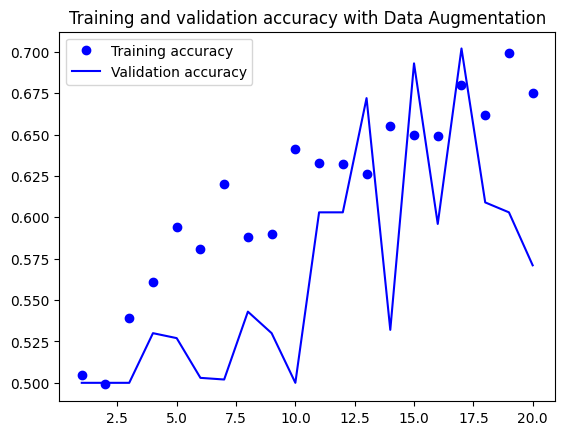

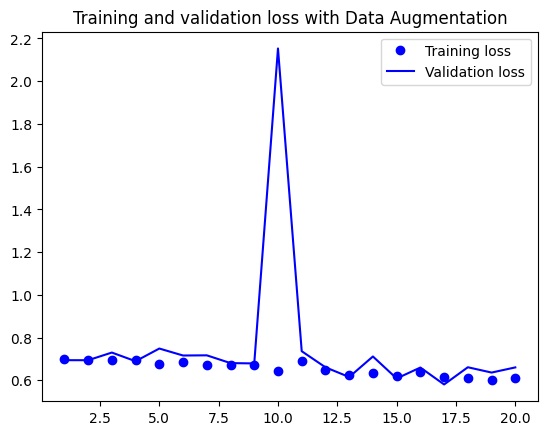

In [48]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy with Data Augmentation")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss with Data Augmentation")
plt.legend()
plt.show()

In [50]:
model = keras.models.load_model("convnet_from_scratch_augmentation.keras")
test_loss, test_acc = model.evaluate(dataset_Testing)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 1s 10ms/step - loss: 0.5959 - accuracy: 0.6710
Test accuracy: 0.671


VGG16 convolutional base

In [51]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [52]:
import numpy as np
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(dataset_Training)
val_features, val_labels = get_features_and_labels(dataset_Validation)
test_features, test_labels = get_features_and_labels(dataset_Testing)

1/1 [==============================] - 1s 870ms/step


Improving the model and freezing the layers

In [53]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Adding a data augmentation stage and classifier to this convolutional base

In [54]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])


callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath="feature_extraction.keras",
 save_best_only=True,
 monitor="val_loss")
]
history = model.fit(
 train_features, train_labels,
 epochs=20,
 validation_data=(val_features, val_labels),
 callbacks=callbacks)

Epoch 1/20
32/32 [==============================] - 1s 19ms/step - loss: 17.5061 - accuracy: 0.9160 - val_loss: 9.5792 - val_accuracy: 0.9460
Epoch 2/20
32/32 [==============================] - 0s 12ms/step - loss: 3.3404 - accuracy: 0.9780 - val_loss: 7.8623 - val_accuracy: 0.9580
Epoch 3/20
32/32 [==============================] - 0s 7ms/step - loss: 1.8666 - accuracy: 0.9820 - val_loss: 9.4706 - val_accuracy: 0.9570
Epoch 4/20
32/32 [==============================] - 0s 7ms/step - loss: 1.6792 - accuracy: 0.9910 - val_loss: 8.2244 - val_accuracy: 0.9580
Epoch 5/20
32/32 [==============================] - 0s 7ms/step - loss: 1.2176 - accuracy: 0.9910 - val_loss: 8.4795 - val_accuracy: 0.9580
Epoch 6/20
32/32 [==============================] - 0s 11ms/step - loss: 0.1544 - accuracy: 0.9980 - val_loss: 7.4617 - val_accuracy: 0.9620
Epoch 7/20
32/32 [==============================] - 0s 7ms/step - loss: 0.1256 - accuracy: 0.9980 - val_loss: 8.3390 - val_accuracy: 0.9610
Epoch 8/20
32/32

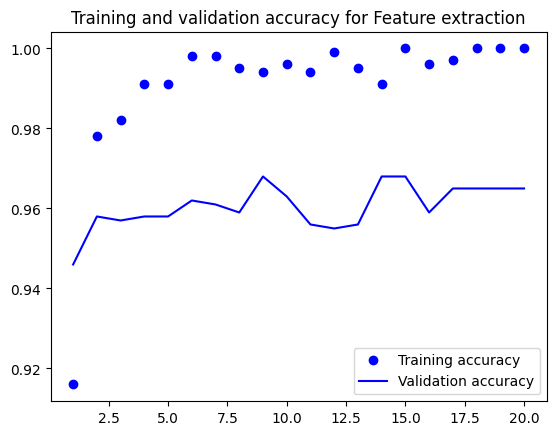

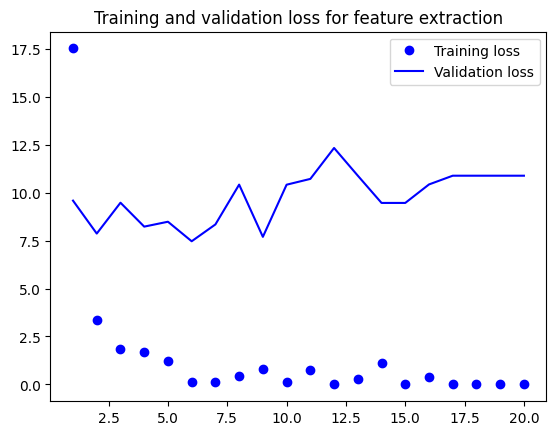

In [55]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy for Feature extraction")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss for feature extraction")
plt.legend()
plt.show()

**Pre-Trained model with 10000 samples**

VGG16 convolutional base

In [56]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

Improving the pretrained model and freezing layers

In [57]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Adding a data augmentation stage and a classifier to this convolutional base

In [58]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.5),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.layers.Lambda(lambda x: keras.applications.vgg16.preprocess_input(x))(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

In [59]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    dataset_Training,
    epochs=20,
    validation_data=dataset_Validation,
    callbacks=callbacks)

Epoch 1/20
32/32 [==============================] - 5s 97ms/step - loss: 5.6823 - accuracy: 0.5910 - val_loss: 1.8550 - val_accuracy: 0.8070
Epoch 2/20
32/32 [==============================] - 3s 90ms/step - loss: 2.6259 - accuracy: 0.6980 - val_loss: 1.0112 - val_accuracy: 0.8640
Epoch 3/20
32/32 [==============================] - 3s 89ms/step - loss: 1.7725 - accuracy: 0.7200 - val_loss: 0.5943 - val_accuracy: 0.8800
Epoch 4/20
32/32 [==============================] - 3s 87ms/step - loss: 1.1226 - accuracy: 0.7800 - val_loss: 0.4094 - val_accuracy: 0.9060
Epoch 5/20
32/32 [==============================] - 3s 89ms/step - loss: 0.7925 - accuracy: 0.7890 - val_loss: 0.3213 - val_accuracy: 0.9140
Epoch 6/20
32/32 [==============================] - 3s 87ms/step - loss: 0.6612 - accuracy: 0.7790 - val_loss: 0.2689 - val_accuracy: 0.9210
Epoch 7/20
32/32 [==============================] - 3s 86ms/step - loss: 0.5077 - accuracy: 0.8140 - val_loss: 0.2221 - val_accuracy: 0.9350
Epoch 8/20
32

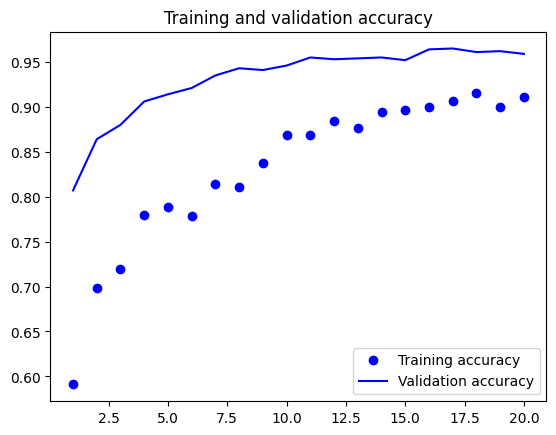

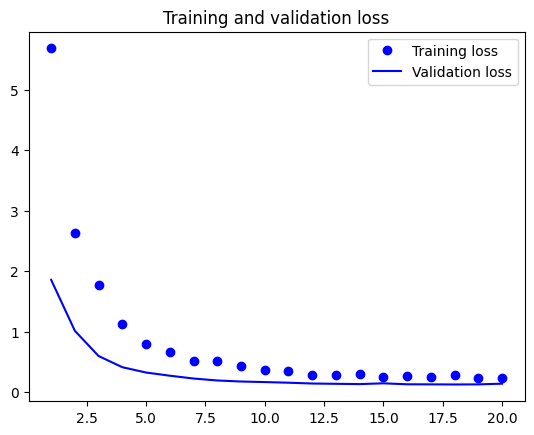

In [60]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [61]:
model_conv1 = keras.models.load_model("fine_tuning.keras", safe_mode=False)
test_loss, test_acc = model_conv1.evaluate(dataset_Testing)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 32ms/step - loss: 0.1454 - accuracy: 0.9585
Test accuracy: 0.959
